### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
## Read Data for Cases, Deaths and Recoveries
confirmed_cases_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [4]:
confirmed_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/27/20,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,12456,13036,13659,14525,15205,15750,16509,17267,18054,18969
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1050,1076,1099,1122,1137,1143,1164,1184,1197,1212
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,8857,8997,9134,9267,9394,9513,9626,9733,9831,9935
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,763,763,764,764,764,765,844,851,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,71,74,81,84,86,86,86,86,86,86


In [5]:
### Melt the dateframe into the right shape and set index
def melt_data(df_raw, drop_country=None):
    df_cleaned = df_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_name='Cases',
                             var_name='Date')
    df_cleaned = df_cleaned.set_index(['Country/Region', 'Province/State', 'Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned


### Get Country-wise Data
def country_wise(df_cleaned, oldname, newname):
    df_country = df_cleaned.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()
    df_country = df_country.set_index(['Country/Region', 'Date'])
    df_country.index = df_country.index.set_levels(
        [df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country = df_country.sort_values(['Country/Region', 'Date'], ascending=True)
    df_country = df_country.rename(columns={oldname: newname})
    return df_country


### Get DailyData from Cumulative sum
def dailydata(dfcountry, oldname, newname):
    dfcountrydaily = dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily = dfcountrydaily.rename(columns={oldname: newname})
    return dfcountrydaily

In [6]:
# Clean all datasets
confirmed_cases = melt_data(confirmed_cases_raw, ['China', 'Mainland China'])
deaths = melt_data(deaths_raw, ['China', 'Mainland China'])
recoveries = melt_data(recoveries_raw, ['China', 'Mainland China'])

In [7]:
confirmed_cases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/20,33.0000,65.0000,0
Albania,NaN,1/22/20,41.1533,20.1683,0
Algeria,NaN,1/22/20,28.0339,1.6596,0
Andorra,NaN,1/22/20,42.5063,1.5218,0
Angola,NaN,1/22/20,-11.2027,17.8739,0


In [8]:
# Get country-wise data
confirmed_cases_country = country_wise(confirmed_cases, 'Cases', 'Total Confirmed Cases')
deaths_country = country_wise(deaths, 'Cases', 'Total Deaths')
recoveries_country = country_wise(recoveries, 'Cases', 'Total Recoveries')

In [9]:
# Get Daily Data
new_cases_country = dailydata(confirmed_cases_country, 'Total Confirmed Cases', 'Daily New Cases')
new_deaths_country = dailydata(deaths_country, 'Total Deaths', 'Daily New Deaths')
new_recoveries_country = dailydata(recoveries_country, 'Total Recoveries', 'Daily New Recoveries')

In [10]:
covid_cases = pd.merge(confirmed_cases_country, new_cases_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, recoveries_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_recoveries_country, how='left', left_index=True, right_index=True)


covid_cases['Active Cases'] = covid_cases['Total Confirmed Cases'] - covid_cases[
    'Total Deaths'] - covid_cases['Total Recoveries']
covid_cases['Share of Recoveries - Closed Cases'] = np.round(covid_cases['Total Recoveries'] / (
        covid_cases['Total Recoveries'] + covid_cases['Total Deaths']), 2)
covid_cases['Death to Cases Ratio'] = np.round(
    covid_cases['Total Deaths'] / covid_cases['Total Confirmed Cases'], 3)


In [11]:
global_totals = covid_cases.reset_index().groupby('Date').sum()
global_totals['Share of Recoveries - Closed Cases'] = np.round(
    global_totals['Total Recoveries'] / (global_totals['Total Recoveries'] + global_totals['Total Deaths']), 2)
global_totals['Death to Cases Ratio'] = np.round(global_totals['Total Deaths'] / global_totals['Total Confirmed Cases'], 3)
global_totals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-06-04,6548814,124339.0,5189.0,386498,2864874,70153.0,3297442,0.88,0.059
2020-06-05,6649911,101097.0,3739.0,390237,2666772,-198102.0,3592902,0.87,0.059


# Plot Global Total Cases

In [12]:
global_totals.iloc[-1]

Total Confirmed Cases                 6649911.000
Daily New Cases                        101097.000
Daily New Deaths                         3739.000
Total Deaths                           390237.000
Total Recoveries                      2666772.000
Daily New Recoveries                  -198102.000
Active Cases                          3592902.000
Share of Recoveries - Closed Cases          0.870
Death to Cases Ratio                        0.059
Name: 2020-06-05 00:00:00, dtype: float64

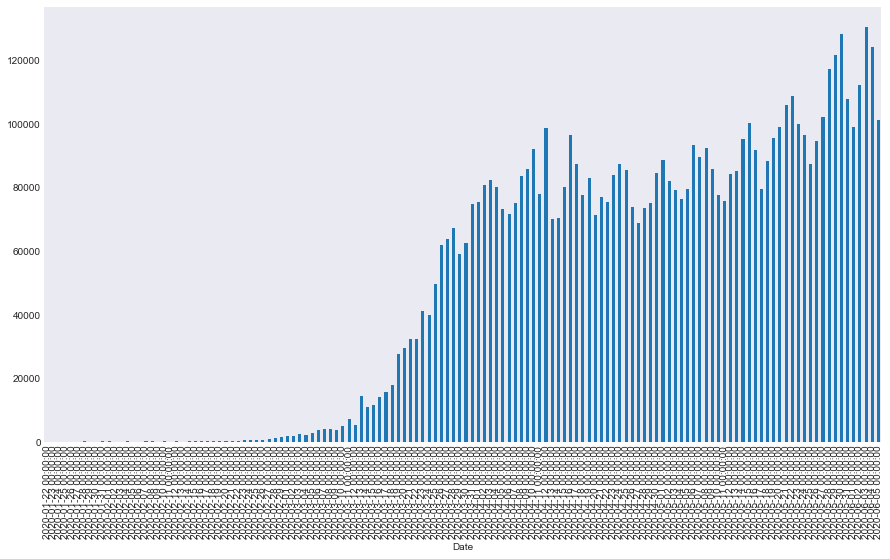

In [13]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['Daily New Cases'].plot.bar()

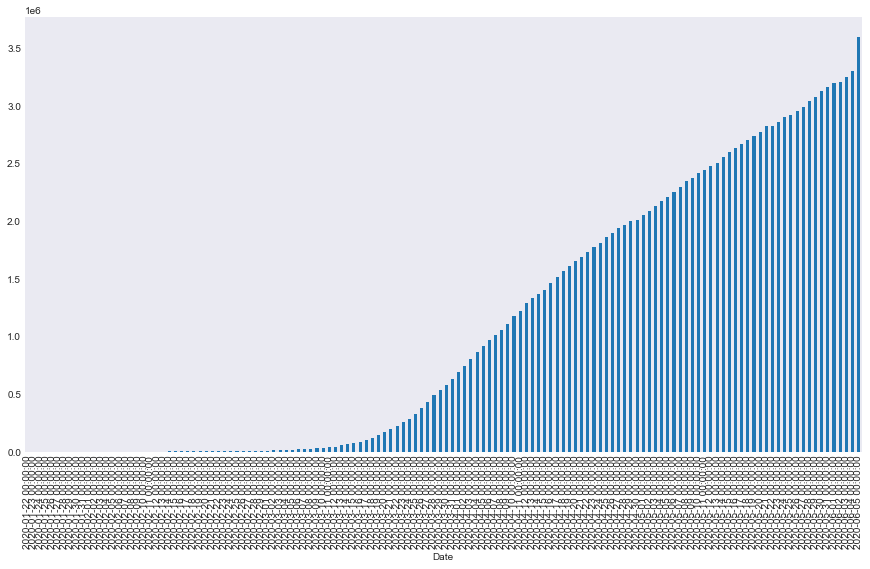

In [14]:
global_totals['Active Cases'].plot.bar()

In [15]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['growth'] = global_totals['Daily New Cases'] / global_totals['Active Cases']

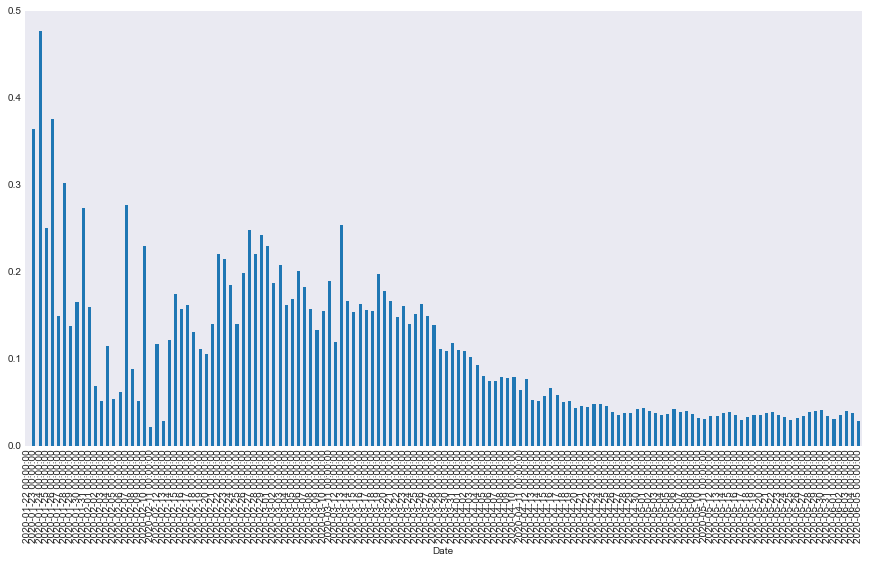

In [16]:
global_totals['growth'].plot.bar()

# Explore Country Specific Data

In [17]:
germany = covid_cases.loc['Germany'].copy()
germany.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-06-01,183594,184.0,15.0,8555,165632,280.0,9407,0.95,0.047
2020-06-02,183879,285.0,8.0,8563,166609,977.0,8707,0.95,0.047
2020-06-03,184121,242.0,39.0,8602,167453,844.0,8066,0.95,0.047
2020-06-04,184472,351.0,33.0,8635,167909,456.0,7928,0.95,0.047
2020-06-05,184924,452.0,23.0,8658,168480,571.0,7786,0.95,0.047


In [18]:
south_korea = covid_cases.loc['Korea, South'].copy()
south_korea.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-06-01,11541,38.0,1.0,272,10446,24.0,823,0.97,0.024
2020-06-02,11590,49.0,1.0,273,10467,21.0,850,0.97,0.024
2020-06-03,11629,39.0,0.0,273,10499,32.0,857,0.97,0.023
2020-06-04,11668,39.0,0.0,273,10506,7.0,889,0.97,0.023
2020-06-05,11719,51.0,0.0,273,10531,25.0,915,0.97,0.023


In [19]:
belgium = covid_cases.loc['Belgium'].copy()
belgium.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-06-01,58517,136.0,19.0,9486,15919,32.0,33112,0.63,0.162
2020-06-02,58615,98.0,19.0,9505,15934,15.0,33176,0.63,0.162
2020-06-03,58685,70.0,17.0,9522,15959,25.0,33204,0.63,0.162
2020-06-04,58767,82.0,26.0,9548,16048,89.0,33171,0.63,0.162
2020-06-05,58907,140.0,18.0,9566,16112,64.0,33229,0.63,0.162


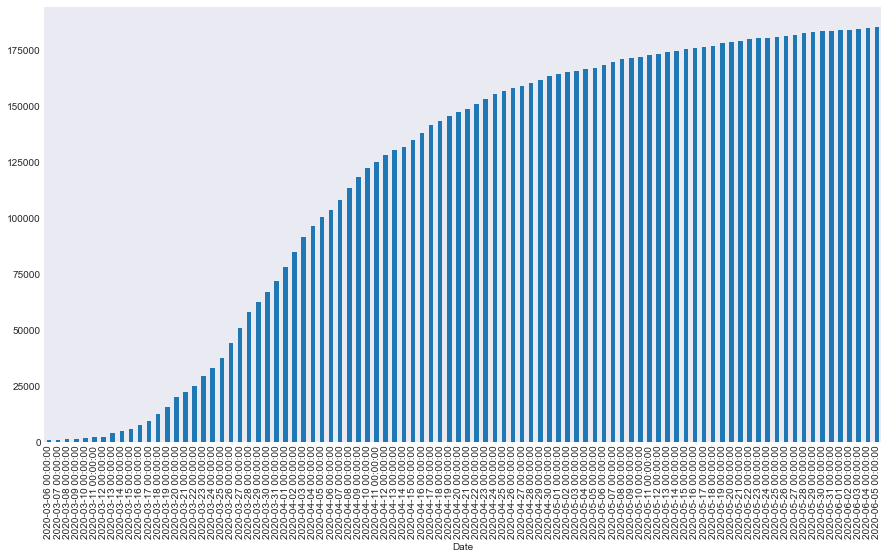

In [20]:
germany['Total Confirmed Cases'].loc['03-06-2020':].plot.bar()

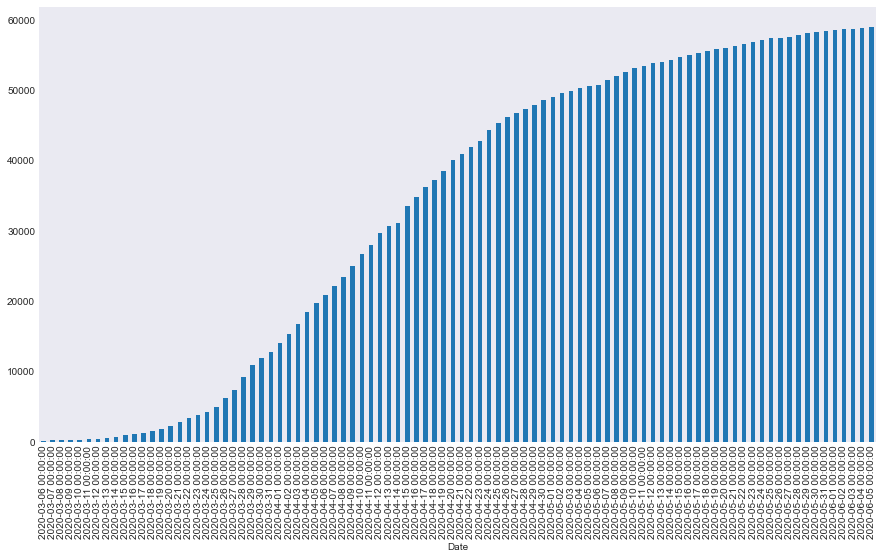

In [21]:
belgium['Total Confirmed Cases'].loc['03-06-2020':].plot.bar()

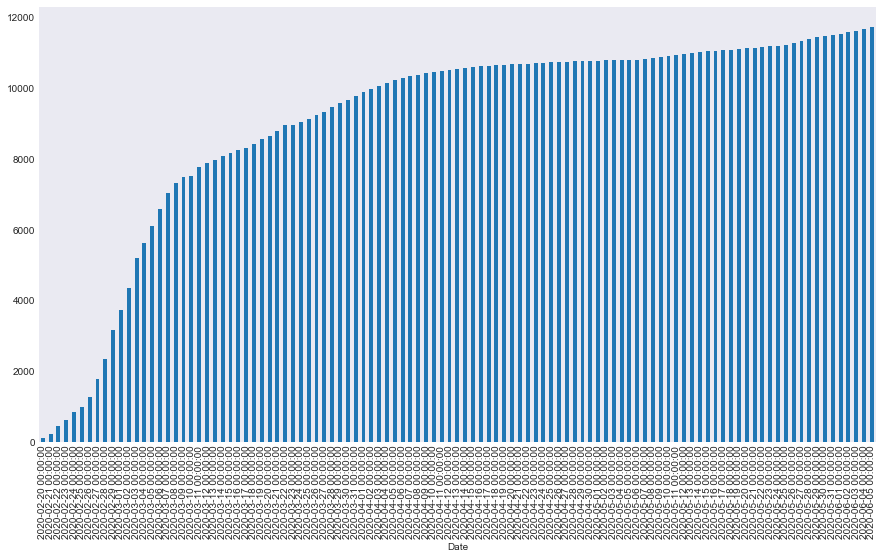

In [22]:
south_korea['Total Confirmed Cases'].loc['02-20-2020':].plot.bar()

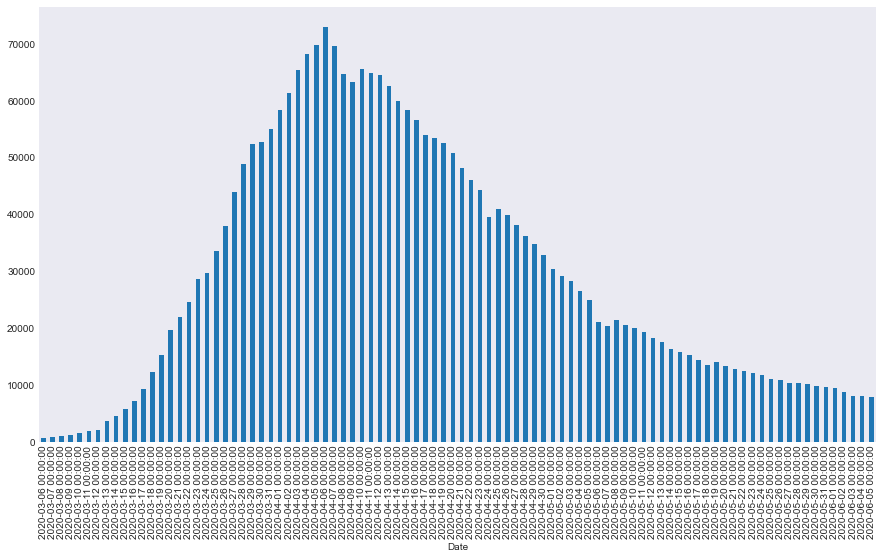

In [23]:
germany['Active Cases'].loc['03-06-2020':].plot.bar()

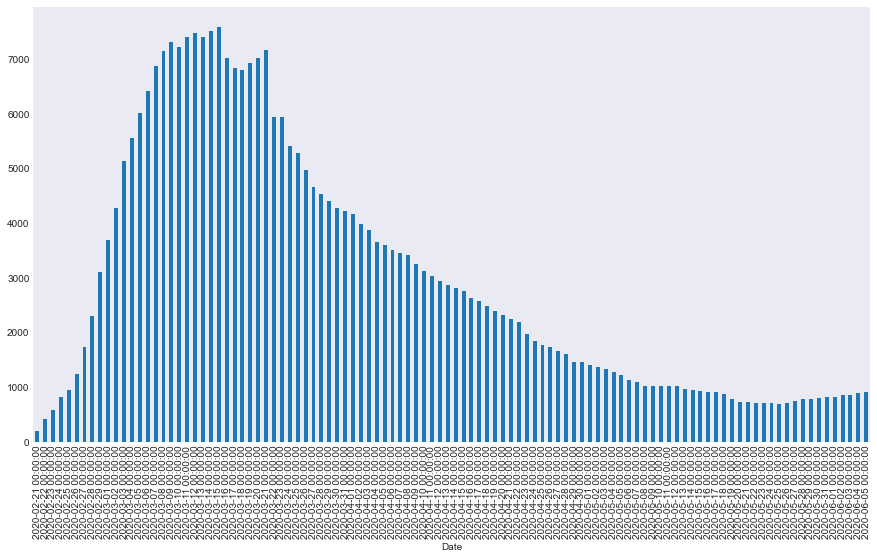

In [24]:
south_korea['Active Cases'].loc['02-21-2020':].plot.bar()

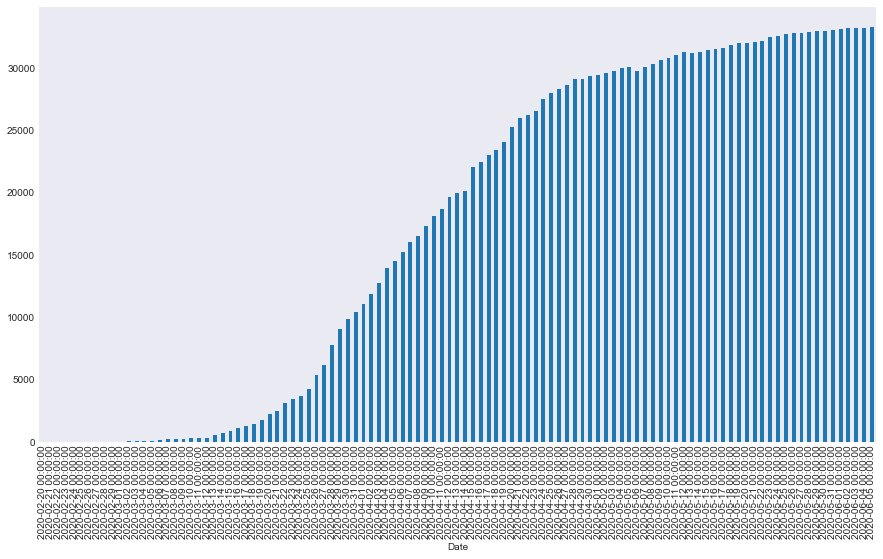

In [25]:
belgium['Active Cases'].loc['02-20-2020':].plot.bar()

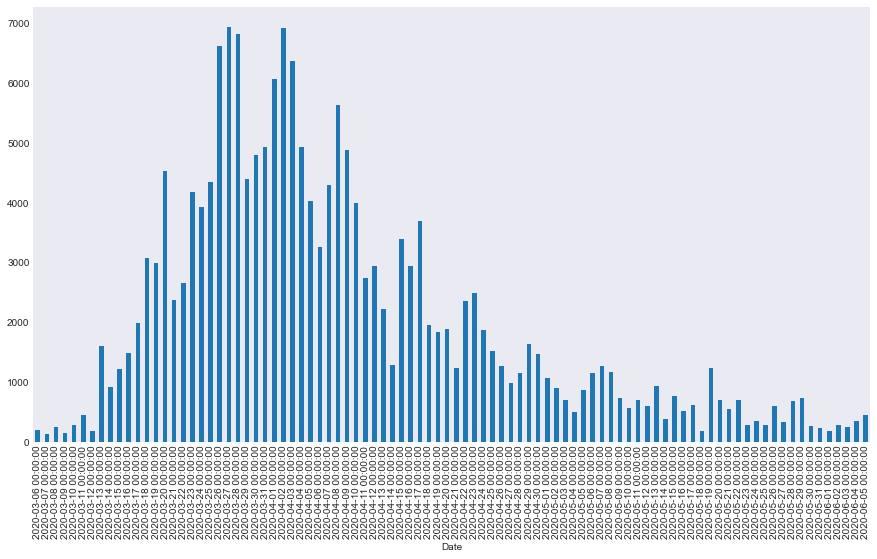

In [26]:
germany['Daily New Cases'].loc['03-06-2020':].plot.bar()

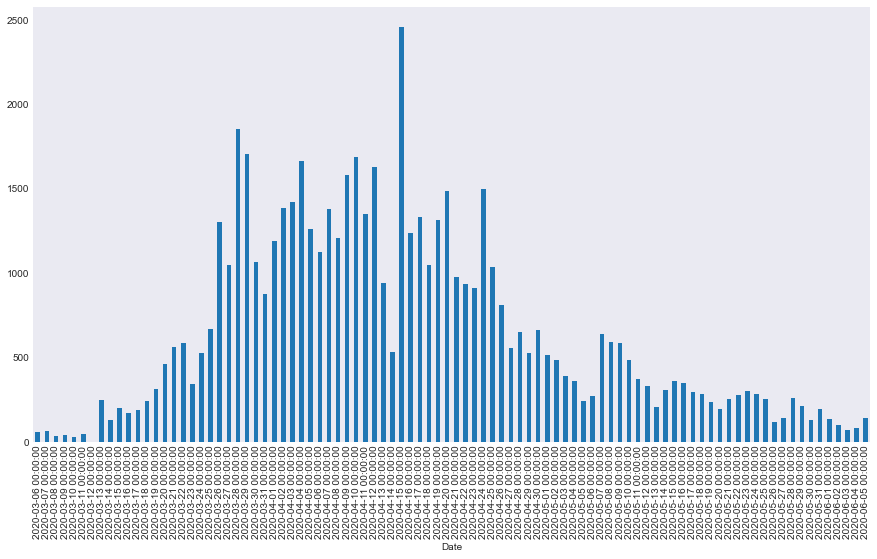

In [27]:
belgium['Daily New Cases'].loc['03-06-2020':].plot.bar()

In [28]:
germany['growth rate'] = germany['Daily New Cases'] / germany['Active Cases']

In [29]:
start_date = '02-25-2020'
past_window = len(germany) - germany['growth rate'].index.get_loc(start_date)
past_window

102

In [30]:
#past_window = 45

In [31]:
germany_growth_moving_average = germany['growth rate'].iloc[-past_window:].rolling(window=3).mean()
germany_growth_ema = germany['growth rate'].iloc[-past_window:].ewm(span=6,adjust=False).mean()

Text(0.5, 1.0, 'Growth = Daily New Cases / Active Cases')

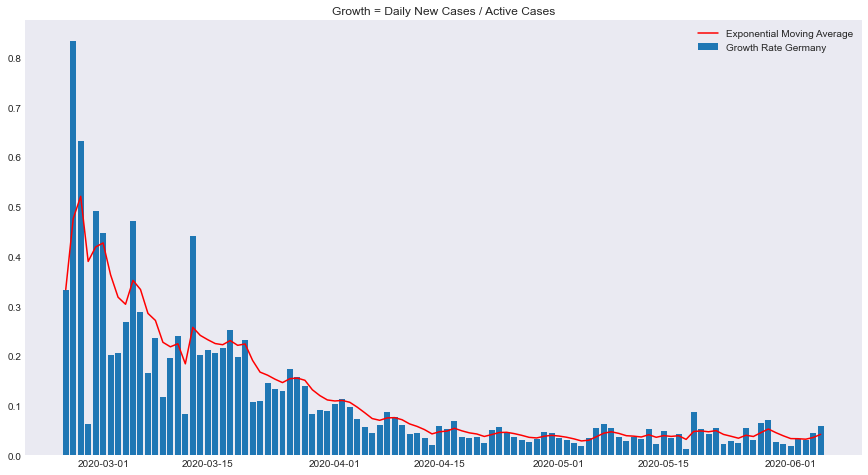

In [32]:
plt.bar(germany.iloc[-past_window:].index, germany['growth rate'].iloc[-past_window:], label='Growth Rate Germany')
#plt.plot(germany_growth_moving_average.index, germany_growth_moving_average, label='Moving Average', color='red')
plt.plot(germany_growth_ema.index, germany_growth_ema, label='Exponential Moving Average', color='red')

plt.legend(loc='best')
plt.title('Growth = Daily New Cases / Active Cases')

In [33]:
germany['growth rate'].tail(10)

Date
2020-05-27    0.031530
2020-05-28    0.064827
2020-05-29    0.071365
2020-05-30    0.027382
2020-05-31    0.023219
2020-06-01    0.019560
2020-06-02    0.032732
2020-06-03    0.030002
2020-06-04    0.044273
2020-06-05    0.058053
Name: growth rate, dtype: float64

In [34]:
south_korea['growth rate'] = south_korea['Daily New Cases'] / south_korea['Active Cases']

In [35]:
belgium['growth rate'] = belgium['Daily New Cases'] / belgium['Active Cases']

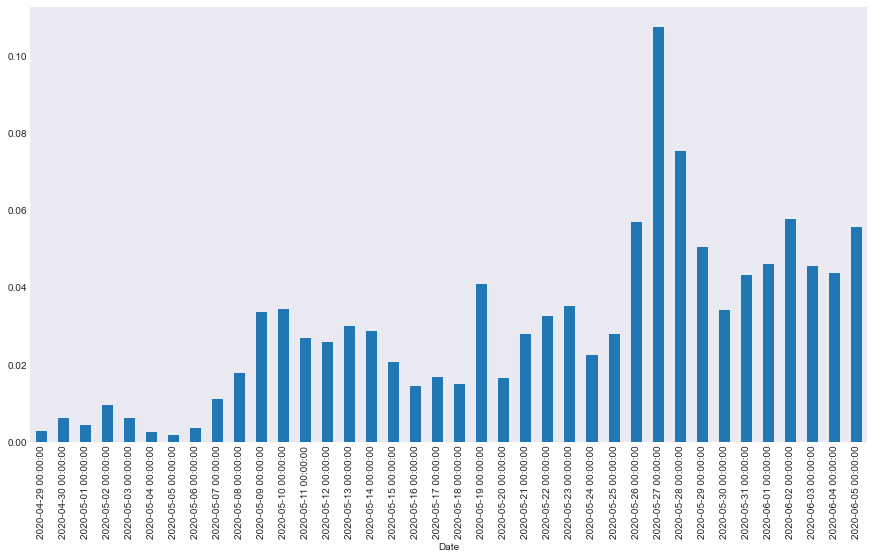

In [36]:
south_korea['growth rate'].iloc[-38:].plot.bar()

Text(0.5, 1.0, 'Growth Belgium')

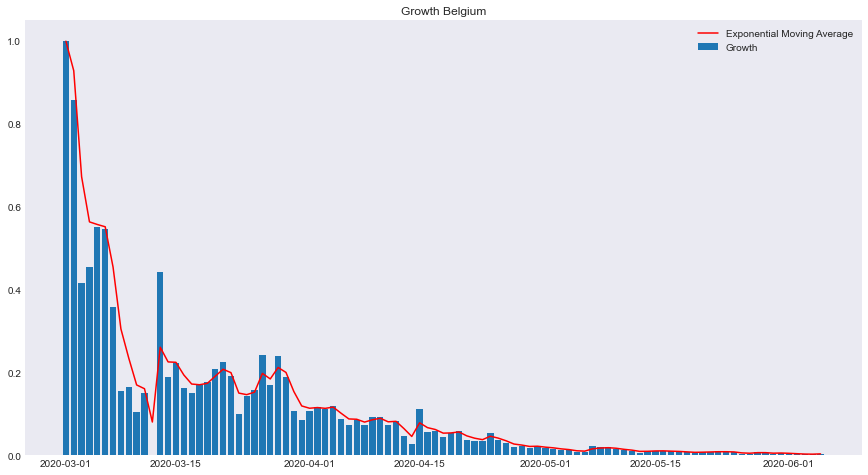

In [37]:
start_date = '03-01-2020'
x = belgium[start_date:].index

plt.bar(x, belgium['growth rate'][start_date:], label='Growth')
plt.plot(x, belgium['growth rate'].ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Belgium')

Text(0.5, 1.0, 'Growth Germany')

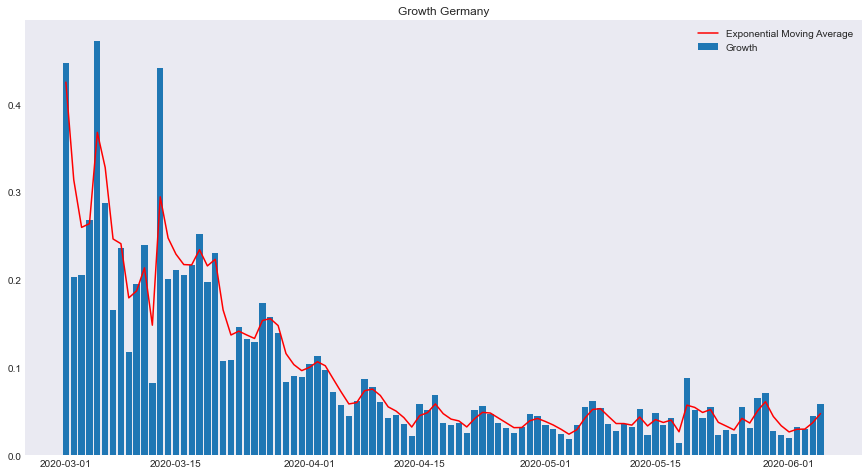

In [38]:
start_date = '03-01-2020'
x = germany[start_date:].index

plt.bar(x, germany['growth rate'][start_date:], label='Growth')
plt.plot(x, germany['growth rate'].ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

In [39]:
south_korea['growth rate'].tail(10)

Date
2020-05-27    0.107483
2020-05-28    0.075325
2020-05-29    0.050388
2020-05-30    0.034048
2020-05-31    0.043210
2020-06-01    0.046173
2020-06-02    0.057647
2020-06-03    0.045508
2020-06-04    0.043870
2020-06-05    0.055738
Name: growth rate, dtype: float64

In [40]:
germany['growth rate'].tail(10)

Date
2020-05-27    0.031530
2020-05-28    0.064827
2020-05-29    0.071365
2020-05-30    0.027382
2020-05-31    0.023219
2020-06-01    0.019560
2020-06-02    0.032732
2020-06-03    0.030002
2020-06-04    0.044273
2020-06-05    0.058053
Name: growth rate, dtype: float64

In [41]:
belgium['growth rate'].tail(10)

Date
2020-05-27    0.004182
2020-05-28    0.007814
2020-05-29    0.006434
2020-05-30    0.003792
2020-05-31    0.005904
2020-06-01    0.004107
2020-06-02    0.002954
2020-06-03    0.002108
2020-06-04    0.002472
2020-06-05    0.004213
Name: growth rate, dtype: float64